# Model_1 (Linear_Model)

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

## 1.1 Creating Dataset (train, test)

In [2]:
# Setup training data
train_data = datasets.FashionMNIST(root='data',
                                   train=True, # That is train data
                                   transform=ToTensor(),
                                   download=True,
                                   target_transform=None)

test_data = datasets.FashionMNIST(root='data',
                                   train=False, # That is train data
                                   transform=ToTensor(),
                                   download=True,
                                   target_transform=None)

100%|██████████| 26421880/26421880 [00:02<00:00, 10334518.90it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 181329.18it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3258273.44it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18646180.48it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
# check on length
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# show clasess
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
# show sample from data
img, label = train_data[0]

# check on img and label
print(f'Image_shape : {img.shape}')
print(f'class_name : {class_names[label]}')

Image_shape : torch.Size([1, 28, 28])
class_name : Ankle boot


## 1.2 Visualize Our dataset

In [6]:
import matplotlib.pyplot as plt

(-0.5, 27.5, 27.5, -0.5)

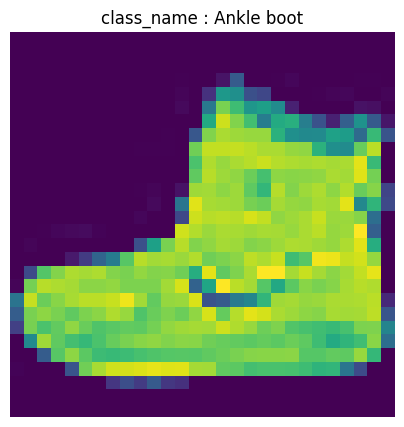

In [7]:
# show sample from data
img, label = train_data[0]

# show figure
plt.figure(figsize=(5, 5))
# change order of tensot into -> (weigth, height, num_channels)
img_permuted = img.permute(1, 2, 0)
plt.imshow(img_permuted)
plt.title(f'class_name : {class_names[label]}')
plt.axis(False)

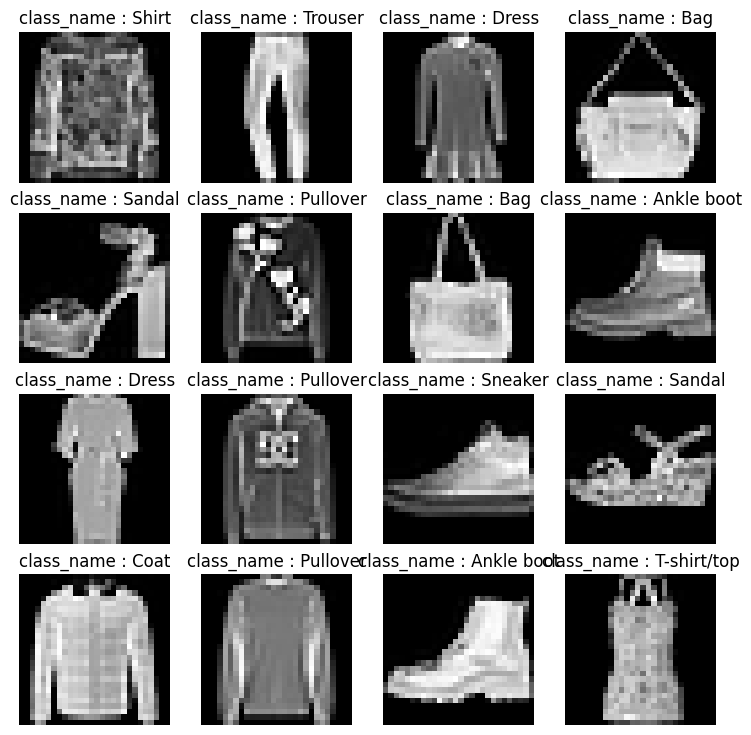

In [8]:
# Visualize more imgs
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols+1) :
  rand_idx = torch.randint(0, len(train_data), size=[1]).item() # .item() to return number not tensor
  # print(rand_idx)
  img, label = train_data[rand_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(f'class_name : {class_names[label]}')
  plt.axis(False)



## 1.3 Convert Our data into Dataloader

In [119]:
# make our dataset with batching
from torch.utils.data import DataLoader

# setup batch_size
BATCH_SIZE = 32

# Turn our train, test data into dataloader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [120]:
len(train_dataloader), len(test_dataloader)

(1875, 1875)

In [121]:
# let's get a batch
train_feature_batch, train_label_batch = next(iter(train_dataloader))
len(train_feature_batch), len(train_label_batch)

(32, 32)

(-0.5, 27.5, 27.5, -0.5)

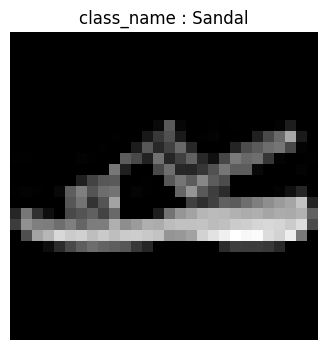

In [12]:
# Let's get a sample random from batch and visualize
plt.figure(figsize=(5,4))

rand_idx = torch.randint(0, len(train_feature_batch), size=[1]).item() # .item() to return number not tensor
img, label = train_feature_batch[rand_idx], train_label_batch[rand_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f'class_name : {class_names[label]}')
plt.axis(False)

## 2.1 Create Class Model

In [13]:
# create device agnositc
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
from torch import nn

class FashionMNISTV1(nn.Module):
  def __init__(self,
               in_shape:int,
               out_shape:int,
               hidden_units:int):
    super().__init__()
    # create layer block
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=in_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=out_shape)
    )

  def forward(self, x:torch.tensor):
    return self.layer_stack(x)

In [15]:
# Create inistanition from model
model_1 = FashionMNISTV1(in_shape=28*28,
                         out_shape=len(class_names),
                         hidden_units=10).to(device)


In [16]:
model_1

FashionMNISTV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

## 2.2 Create Loss_fn, optimizer and evaluation metrics

In [17]:
# download helper function
import requests
from pathlib import Path

try:
  print(f"Downloading helper_functions.py")

  request = requests.get('https://raw.githubusercontent.com/es-OmarHani/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f :
    f.write(request.content)

except:
  print(f"helper_functions.py is already exist")

In [18]:
from helper_functions import accuracy_fn

# create loss
loss_fn = nn.CrossEntropyLoss()
# create optim
optimizer = torch.optim.SGD(params=model_1.parameters(),
                         lr=0.1)

## 2.3 Creat a function that calculate time of trainig model

In [19]:
from timeit import default_timer as timer

def print_total_time(start:float,
                     end:float,
                     device:torch.device=device):
  # show time
  total_time = end-start

  # show device with time
  print(f'total_time on {device} is : {total_time}')

  return total_time

In [20]:
# test our method
start=timer()
pass
end=timer()
print_total_time(start, end)

total_time on cuda is : 8.283700003630656e-05


8.283700003630656e-05

## 2.4 Creting a training and testing loop


In [21]:
from tqdm.auto import tqdm

# set seed
torch.manual_seed(42)
train_start_time_gpu = timer()

# set num epochs
epochs = 3

# creating train loop and testing
for epoch in tqdm(range(epochs)) :
  ### testing
  model_1.train()

  train_loss = 0
  train_acc = 0

  # loop through train_dataloader
  for batch, (X_train, y_train) in enumerate(train_dataloader):
    # put data on device
    X_train, y_train = X_train.to(device), y_train.to(device)

    # 1. forward pass
    train_pred = model_1(X_train)

    # 2. loss_fn
    loss = loss_fn(train_pred, y_train)
    train_loss += loss
    train_acc += accuracy_fn(y_train, train_pred.argmax(dim=1))

    # 3. optim zero grad
    optimizer.zero_grad()

    # 4. loss_backward
    loss.backward()

    # 5. optmizer step
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X_train)}/{len(train_dataloader.dataset)} samples")



  # let's divide on total_train_dataloader
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  ### testing
  model_1.eval()

  test_loss = 0
  test_acc  = 0

  with torch.inference_mode() :
    # loop through data
    for X_test, y_test in test_dataloader :
      # put data on device
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. forward pass
      test_pred = model_1(X_test)

      # 2. test_loss, test_acc
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

    # let's divide on total_train_dataloader
    test_loss /= len(train_dataloader)
    test_acc /= len(train_dataloader)

  # print what is hapining?!
  print(f'Train_loss : {train_loss:.4f} | Train_acc : {train_acc:.4f} | Test_loss : {test_loss:.4f} | Test_acc : {test_acc:.4f}')


# calulcate end time
train_end_ime_gpu = timer()
total_train_time_gpu = print_total_time(start=train_start_time_gpu,
                                        end=train_end_ime_gpu,
                                        device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train_loss : 0.6187 | Train_acc : 77.8267 | Test_loss : 0.4555 | Test_acc : 83.5283
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train_loss : 0.4582 | Train_acc : 83.4467 | Test_loss : 0.4376 | Test_acc : 84.6883
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train_loss : 0.4306 | Train_acc : 84.4600 | Test_loss : 0.4308 | Test_acc : 84.7783
total_time on cuda is : 56.120107099999984


## 2.5 Writing an eval_method

In [22]:
def eval_model(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn,
               accuracy_fn=accuracy_fn):

  model.eval()

  eval_loss = 0
  eval_acc  = 0

  with torch.inference_mode() :
    # loop through data
    for X, y in test_dataloader :
      # put data on device
      X, y = X.to(device), y.to(device)

      # 1. forward pass
      y_preds = model(X)

      # 2. test_loss, test_acc
      eval_loss += loss_fn(y_preds, y)
      eval_acc += accuracy_fn(y, y_preds.argmax(dim=1))

    # let's divide on total_train_dataloader
    eval_loss /= len(dataloader)
    eval_acc /= len(dataloader)

  return {'model_name' : model.__class__.__name__,
          'model_loss': eval_loss.item(),
          'model_acc' : eval_acc}

In [23]:
# calc model_1 results
model_1_res = eval_model(model_1,
                         dataloader=test_dataloader,
                         loss_fn=loss_fn)
model_1_res

{'model_name': 'FashionMNISTV1',
 'model_loss': 0.4308488667011261,
 'model_acc': 84.77833333333334}

## 3.1 Create MOethods for train and testing loop

In [24]:
# create train_method
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim,
               accuracy_fn=None,
               device:torch.device = device):
  """
  Method that create train loop over all dataset
  """

  ### testing
  model.train()

  train_loss = 0
  train_acc = 0

  # loop through dataloader
  for batch, (X_train, y_train) in enumerate(dataloader):
    # put data on device
    X_train, y_train = X_train.to(device), y_train.to(device)

    # 1. forward pass
    train_pred = model(X_train)

    # 2. loss_fn
    loss = loss_fn(train_pred, y_train)
    train_loss += loss
    train_acc += accuracy_fn(y_train, train_pred.argmax(dim=1))

    # 3. optim zero grad
    optimizer.zero_grad()

    # 4. loss_backward
    loss.backward()

    # 5. optmizer step
    optimizer.step()

    # Print out how many samples have been seen
    if batch % 400 == 0:
        print(f"Looked at {batch * len(X_train)}/{len(dataloader.dataset)} samples")



  # let's divide on total_train_dataloader
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

In [25]:
# create train_method
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn=None,
               device:torch.device = device):
  """
  Method that create test loop over all dataset
  """

  ### testing
  model.eval()

  test_loss = 0
  test_acc  = 0

  with torch.inference_mode() :
    # loop through data
    for X_test, y_test in dataloader :
      # put data on device
      X_test, y_test = X_test.to(device), y_test.to(device)

      # 1. forward pass
      test_pred = model(X_test)

      # 2. test_loss, test_acc
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

    # let's divide on total_train_dataloader
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

# Model_2 (CNN Model)

## Creating Model

In [122]:
from torch import nn

class FashionMNISTV2(nn.Module):
  def __init__(self,
               in_shape:int,
               out_shape:int,
               hidden_units:int):
    super().__init__()
    # create layers block
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

    self.classifer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=out_shape)
        )

  def forward(self, x:torch.tensor):
    x = self.conv_block_1(x)
    # print(f'x_shape from conv_block_1 : {x.shape}')
    x = self.conv_block_2(x)
    # print(f'x_shape from conv_block_2 : {x.shape}')
    x = self.classifer(x)
    # print(f'x_shape from conv_block_1 : {x.shape}')
    return x

In [123]:
# create an instationation from class
model_2 = FashionMNISTV2(in_shape=1,
                         out_shape=len(class_names),
                         hidden_units=10).to(device)
model_2

FashionMNISTV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [124]:
# Let's check on image
# creat img
rand_img_tenosr = torch.rand(size=(1, 28, 28)).to(device)

# pass img into model
model_2(rand_img_tenosr.unsqueeze(0))

tensor([[ 0.0143,  0.0494,  0.0359, -0.0393, -0.0493,  0.0161, -0.0662, -0.0543,
         -0.0077, -0.0172]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [125]:
# Let's check on image
# creat img
rand_img_tenosr = torch.rand(size=(1, 28, 28)).to(device)

# pass img into model
model_2(rand_img_tenosr.unsqueeze(0))

tensor([[ 0.0159,  0.0589,  0.0383, -0.0381, -0.0544,  0.0092, -0.0581, -0.0614,
         -0.0054, -0.0199]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Creating loss_fn and optimizer

In [126]:
from helper_functions import accuracy_fn

# create loss
loss_fn = nn.CrossEntropyLoss()
# create optim
optimizer = torch.optim.SGD(params=model_2.parameters(),
                         lr=0.01)

## Creating training, testing methods

In [127]:
# mesure time
from timeit import default_timer as timer
train_start_time = timer()

# num of epochs
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f'Epoch : {epoch}\n---------')

  # training loop
  train_loss, train_acc = train_step(model=model_2,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    accuracy_fn=accuracy_fn,
                                    device=device)

  # testing loop
  test_loss, test_acc = test_step(model=model_2,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)
  # print what is hapining?!
  print(f'Train_loss : {train_loss:.4f} | Train_acc : {train_acc:.4f} | Test_loss : {test_loss:.4f} | Test_acc : {test_acc:.4f}')


# calulcate end time
train_end_time = timer()
total_train_time = print_total_time(start=train_start_time,
                                        end=train_end_time,
                                        device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train_loss : 1.1069 | Train_acc : 61.5350 | Test_loss : 0.5464 | Test_acc : 80.2867
Epoch : 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train_loss : 0.4904 | Train_acc : 82.2700 | Test_loss : 0.4224 | Test_acc : 84.9033
Epoch : 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train_loss : 0.4208 | Train_acc : 84.8667 | Test_loss : 0.4259 | Test_acc : 84.2483
total_time on cuda is : 54.50670129399987


In [128]:
# Let's get results
model_2_res = eval_model(model_2,
                         dataloader=test_dataloader,
                         loss_fn=loss_fn)
model_2_res

{'model_name': 'FashionMNISTV2',
 'model_loss': 0.42586493492126465,
 'model_acc': 84.24833333333333}

## Compare Results

In [129]:
import pandas as pd

compare_results = pd.DataFrame([model_1_res,
                                model_2_res])

In [130]:
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTV1,0.430849,84.778333
1,FashionMNISTV2,0.425865,84.248333


## Create Function for preds

In [131]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [132]:
list(pred_probs)

[tensor([1.8654e-07, 6.1120e-09, 3.1307e-08, 7.7045e-09, 1.2123e-08, 9.6224e-01,
         3.9085e-07, 2.2788e-04, 6.9086e-05, 3.7464e-02]),
 tensor([1.7727e-02, 6.3526e-01, 1.0395e-03, 3.0568e-01, 3.6463e-02, 2.3995e-06,
         3.6416e-03, 1.3215e-05, 1.6915e-04, 7.4265e-06]),
 tensor([3.8363e-07, 6.2776e-09, 1.2510e-07, 1.7631e-07, 4.7282e-08, 1.4782e-02,
         1.8079e-06, 3.4487e-01, 7.5074e-04, 6.3959e-01]),
 tensor([5.0274e-04, 1.3359e-04, 3.4029e-01, 1.9720e-03, 6.4673e-01, 5.8666e-09,
         1.0019e-02, 2.6596e-09, 3.5372e-04, 2.5160e-08]),
 tensor([1.0351e-02, 3.4735e-04, 1.7804e-05, 9.8186e-01, 1.0770e-04, 1.4445e-08,
         7.3030e-03, 2.4247e-07, 5.4330e-06, 8.6897e-06]),
 tensor([3.8118e-01, 8.0791e-05, 7.1758e-04, 5.1962e-03, 1.9117e-03, 5.4784e-09,
         6.1085e-01, 8.6907e-09, 5.6644e-05, 5.7551e-08]),
 tensor([8.8056e-06, 2.4909e-06, 9.2018e-03, 9.0252e-07, 9.3504e-01, 6.6867e-08,
         5.5700e-02, 1.2391e-12, 4.9490e-05, 7.8410e-10]),
 tensor([2.6185e-05,

In [133]:
torch.stack(list(pred_probs))

tensor([[1.8654e-07, 6.1120e-09, 3.1307e-08, 7.7045e-09, 1.2123e-08, 9.6224e-01,
         3.9085e-07, 2.2788e-04, 6.9086e-05, 3.7464e-02],
        [1.7727e-02, 6.3526e-01, 1.0395e-03, 3.0568e-01, 3.6463e-02, 2.3995e-06,
         3.6416e-03, 1.3215e-05, 1.6915e-04, 7.4265e-06],
        [3.8363e-07, 6.2776e-09, 1.2510e-07, 1.7631e-07, 4.7282e-08, 1.4782e-02,
         1.8079e-06, 3.4487e-01, 7.5074e-04, 6.3959e-01],
        [5.0274e-04, 1.3359e-04, 3.4029e-01, 1.9720e-03, 6.4673e-01, 5.8666e-09,
         1.0019e-02, 2.6596e-09, 3.5372e-04, 2.5160e-08],
        [1.0351e-02, 3.4735e-04, 1.7804e-05, 9.8186e-01, 1.0770e-04, 1.4445e-08,
         7.3030e-03, 2.4247e-07, 5.4330e-06, 8.6897e-06],
        [3.8118e-01, 8.0791e-05, 7.1758e-04, 5.1962e-03, 1.9117e-03, 5.4784e-09,
         6.1085e-01, 8.6907e-09, 5.6644e-05, 5.7551e-08],
        [8.8056e-06, 2.4909e-06, 9.2018e-03, 9.0252e-07, 9.3504e-01, 6.6867e-08,
         5.5700e-02, 1.2391e-12, 4.9490e-05, 7.8410e-10],
        [2.6185e-05, 1.3769

In [134]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [135]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                        data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.3371e-07, 4.6345e-08, 1.3691e-07, 4.0741e-08, 5.9826e-08, 9.8836e-01,
         2.1576e-07, 2.3094e-05, 2.7638e-05, 1.1586e-02],
        [7.9722e-02, 7.0651e-01, 5.9263e-04, 1.4883e-01, 3.0418e-02, 4.5066e-05,
         2.8641e-02, 6.0765e-04, 4.5880e-03, 4.5639e-05]])

In [136]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1])

## Visualize Some imgs

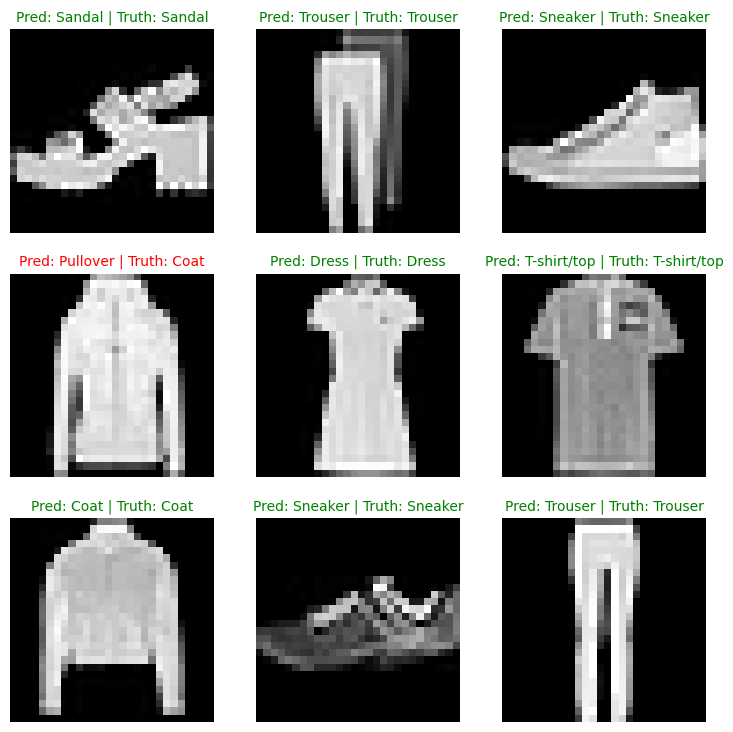

In [137]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## Creaing and plotting conf mat

In [155]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
count = 0

model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc='Making Predictions..'):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)

    # print what's happening?!
    count += 1
    if count % 800 == 0 :
      print(f"y_logit : {y_logit[:3]} | y_logit_shape : {y_logit.shape} | y_pred : {y_pred}| y_pred_len : {len(y_pred)}\n")

    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making Predictions..:   0%|          | 0/1875 [00:00<?, ?it/s]

y_logit : tensor([[-3.5777, -2.3215, -3.4722, -3.2840, -1.4760,  3.9657, -1.3562, -2.0599,
          2.6646, 11.0387],
        [ 4.8771,  0.1249,  0.4082,  5.1908,  2.7401, -5.2699,  4.6986, -4.1032,
          3.9068, -7.2849],
        [ 2.2248, -5.2853,  0.5993, -5.0415, -0.5943, -3.0926,  2.7415, -0.8443,
         11.0252,  1.2723]], device='cuda:0') | y_logit_shape : torch.Size([32, 10]) | y_pred : tensor([9, 3, 8, 1, 2, 2, 7, 6, 3, 8, 8, 1, 8, 8, 6, 7, 2, 3, 9, 2, 2, 9, 1, 0,
        9, 3, 2, 2, 9, 0, 2, 6], device='cuda:0')| y_pred_len : 32

y_logit : tensor([[ 1.3863,  0.4590,  9.0232,  0.9622,  8.0345, -5.1642,  7.3883, -9.6247,
          1.2918, -8.9528],
        [-3.5516, -3.5163, -3.1860, -2.6735, -3.3053,  6.2208, -2.4846, 10.1826,
          3.3296,  0.6233],
        [ 0.9071, 11.0191, -3.0506,  2.2638,  1.2831, -0.9908, -2.2895, -2.7221,
         -0.0410, -5.1379]], device='cuda:0') | y_logit_shape : torch.Size([32, 10]) | y_pred : tensor([2, 7, 1, 5, 6, 2, 9, 9, 1, 4, 6, 3

tensor([1, 2, 8, 3, 2, 8, 8, 2, 6, 7])

In [139]:
y_pred_tensor[:10], y_preds[:5]

(tensor([8, 0, 0, 5, 2, 3, 7, 3, 7, 5]),
 [tensor([8, 0, 0, 5, 2, 3, 7, 3, 7, 5, 7, 3, 2, 3, 2, 7, 7, 8, 7, 0, 8, 2, 6, 0,
          7, 7, 2, 1, 9, 8, 1, 3]),
  tensor([7, 8, 9, 2, 5, 2, 0, 0, 7, 3, 6, 8, 8, 9, 7, 4, 7, 9, 0, 0, 4, 7, 4, 3,
          5, 6, 6, 7, 4, 8, 4, 8]),
  tensor([5, 7, 6, 2, 5, 1, 0, 8, 8, 0, 5, 3, 2, 9, 7, 2, 8, 5, 6, 2, 4, 5, 9, 6,
          8, 1, 1, 1, 3, 9, 1, 7]),
  tensor([5, 7, 2, 9, 8, 2, 5, 9, 0, 3, 3, 1, 7, 8, 8, 6, 9, 1, 9, 1, 3, 9, 3, 4,
          1, 6, 8, 3, 6, 5, 5, 5]),
  tensor([5, 9, 2, 0, 5, 4, 0, 0, 4, 3, 2, 6, 2, 3, 5, 3, 5, 1, 1, 5, 0, 4, 3, 6,
          6, 9, 7, 5, 2, 5, 2, 2])])

In [140]:
y_preds[0], len(y_preds[0]), len(y_preds)

(tensor([8, 0, 0, 5, 2, 3, 7, 3, 7, 5, 7, 3, 2, 3, 2, 7, 7, 8, 7, 0, 8, 2, 6, 0,
         7, 7, 2, 1, 9, 8, 1, 3]),
 32,
 1875)

In [141]:
len(class_names)

10

In [142]:
torch.cat(y_preds)[:10], len(torch.cat(y_preds))

(tensor([8, 0, 0, 5, 2, 3, 7, 3, 7, 5]), 60000)

In [143]:
len(y_preds), len(y_pred_tensor)

(1875, 60000)

In [144]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.0


In [145]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.0


In [146]:
y_pred_tensor.shape, test_data.targets.shape

(torch.Size([60000]), torch.Size([10000]))

In [147]:
y_pred_tensor[:10]

tensor([8, 0, 0, 5, 2, 3, 7, 3, 7, 5])

In [148]:
len(test_data.targets)

10000

In [154]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

y_pred_tensor[:10]

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

ValueError: ignored